In [32]:
import sys
import networkx as nx
import numpy as np
import random
from collections import defaultdict
import torch
import math
import importlib
import pandas as pd
#torch.set_num_threads(1)

sys.path.insert(0, '../../')
import python_lib.graph_gen as graph_gen
import python_lib.models as models
#from python_lib import solvers

import glob

In [33]:
%matplotlib inline


In [34]:
def file_name(args, net=False):
    if args.save_net == "yes":
        if not os.path.exists(args.save_dir+"nets/"):
            os.makedirs(args.save_dir+"nets/")

    if net:
        return args.save_dir + "nets/" + f"N{args.N}_seed{args.seed}_model{args.model}_net_spec{args.net_spec}_J{args.J:.2}_h{args.h:.2}_lr{args.lr:.2}_max_step{args.max_step}_batch_size{args.batch_size}_std_fe_limit{args.std_fe_limit:.2}"
    else:
        return args.save_dir + f"N{args.N}_seed{args.seed}_model{args.model}_net_spec{args.net_spec}"


In [35]:
data_dir = "data/"
files = glob.glob(data_dir+"*.gzip")
# print(files)


In [36]:
model = "SK"
hh = 0.
JJ = 1.
Ns = [20, 50, 100, 200]
net_specs = ["exact"]
data_exact = pd.DataFrame()
seeds = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
for seed in seeds:
    for N in Ns:
        for net_spec in net_specs:
            name_f = f"N{N}_seed{seed}_model{model}_net_spec{net_spec}"
            res = [i for i in files if name_f in i]
            if len(res) == 1:
                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data_exact = pd.concat([data_exact, df_], ignore_index=True)
                print(f"read: {res[0]}")
            elif len(res) > 1:
                print(res)

                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data_exact = pd.concat([data_exact, df_], ignore_index=True)
                print(f"read: {res[0]}")
            else:
                print("not found")


not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found
not found


In [37]:
net_specs = ["SK_0rsb", "SK_1rsb", "SK_2rsb", "SL",
             "MADE_21", "MADE_22", "MADE_23", "MADE_32"]
data = pd.DataFrame()
for seed in seeds:
    for N in Ns:
        for net_spec in net_specs:
            name_f = f"N{N}_seed{seed}_model{model}_net_spec{net_spec}"
            res = [i for i in files if name_f in i]
            if len(res) == 1:
                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data = pd.concat([data, df_], ignore_index=True)
                print(f"read: {res[0]}")
            elif len(res) > 1:
                print(res)

                def repl(name_col):
                    return name_col.replace(net_spec, "")
                df_ = pd.read_pickle(res[0])
                df_ = df_.rename(repl, axis='columns')
                data = pd.concat([data, df_], ignore_index=True)
                print(f"read: {res[0]}")


read: data/N50_seed1_modelSK_net_specSK_0rsb_20230814_155835.gzip
read: data/N50_seed1_modelSK_net_specSK_1rsb_20230814_154952.gzip
read: data/N50_seed1_modelSK_net_specSK_2rsb_20230814_162053.gzip
read: data/N50_seed1_modelSK_net_specSL_20230814_140612.gzip
read: data/N50_seed1_modelSK_net_specMADE_23_20230814_141831.gzip
read: data/N50_seed1_modelSK_net_specMADE_32_20230814_144140.gzip
read: data/N100_seed1_modelSK_net_specSK_0rsb_20230308_032849.gzip
read: data/N100_seed1_modelSK_net_specSK_1rsb_20230308_052652.gzip
read: data/N100_seed1_modelSK_net_specSK_2rsb_20230308_203105.gzip
['data/N100_seed1_modelSK_net_specSL_20230307_233719.gzip', 'data/N100_seed1_modelSK_net_specSL_20230814_142936.gzip']
read: data/N100_seed1_modelSK_net_specSL_20230307_233719.gzip
['data/N100_seed1_modelSK_net_specMADE_23_20230814_163605.gzip', 'data/N100_seed1_modelSK_net_specMADE_23_20230308_011514.gzip']
read: data/N100_seed1_modelSK_net_specMADE_23_20230814_163605.gzip
read: data/N100_seed1_modelSK_n

In [38]:
data['seed'] = data['seed'].astype('int')
data['N'] = data['N'].astype('int')
data['beta'] = data['beta'].astype('float')
#data_exact['seed'] = data_exact['seed'].astype('int')
#data_exact['N'] = data_exact['N'].astype('int')


In [39]:
data["err_fe"] = 0
data["err_fe_rel"] = 0
for N in Ns:
    print(N)
    for seed in seeds:
        d_ = data[(data["N"] == N) & (data["seed"] == seed)]
        to_set = []
        to_set_res = []

        for index, row in d_.iterrows():
            beta = row["beta"]
            net_spec = "SK_2rsb"
            fe_ex = d_[(np.abs(d_["beta"]-beta) < 1e-6) &
                       (d_["net_spec"] == net_spec)]["free_energy_mean"].item()
            vv = d_.loc[index]["free_energy_mean"].item() - fe_ex
            data.at[index, "err_fe"] = vv
            data.at[index, "err_fe_rel"] = vv / np.abs(fe_ex)
        #data_all[N] = data[N].copy()


20
50
100
200


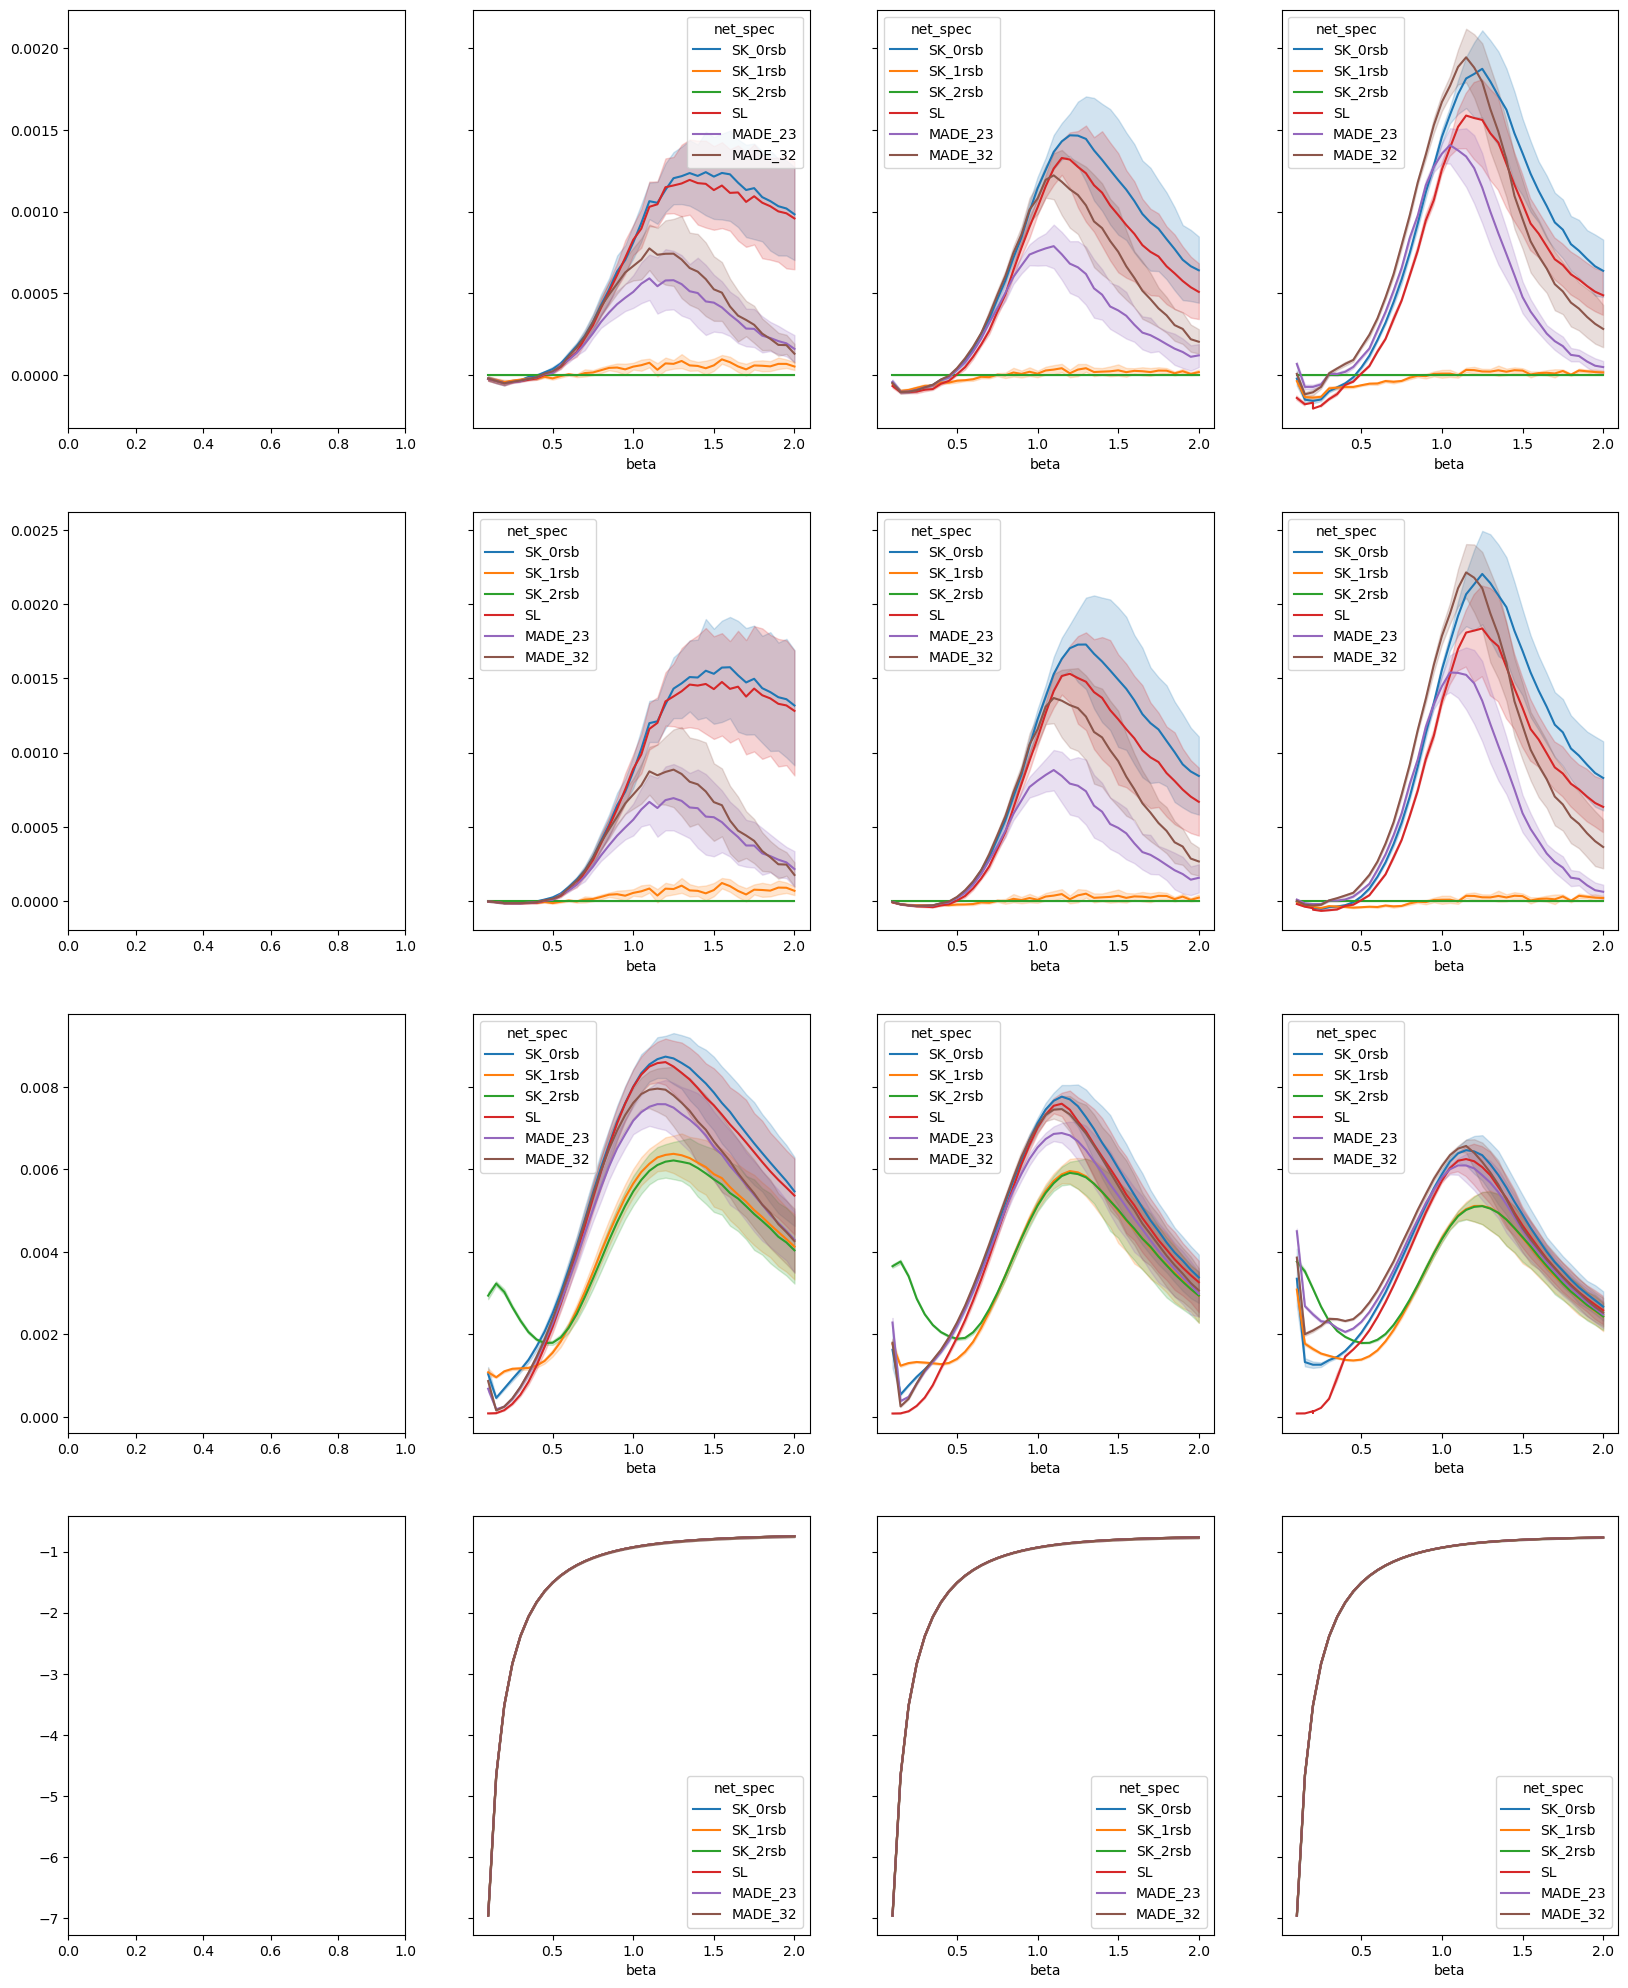

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

Ns = [20, 50, 100, 200]
fig, axs = plt.subplots(4, 4, figsize=(20, 25), sharey="row")

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="err_fe",
                 hue="net_spec", ax=axs[0][i], legend="full")

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="err_fe_rel",
                 hue="net_spec", ax=axs[1][i], legend="full")

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="free_energy_std",
                 hue="net_spec", ax=axs[2][i], legend="full")

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    sns.lineplot(data=d_, x="beta", y="free_energy_mean",
                 hue="net_spec", ax=axs[3][i], legend="full")


In [41]:
beta = 2
N = 200
df_beta = data[(np.abs(data["beta"] - beta) < 1e-6) & (data["N"] == N)]


In [42]:
df_q = []
m = 2000
for e in df_beta.iterrows():
    for ii, qq in enumerate(e[1]["q"]):
        df_q.append({"q": qq.numpy()/(m**2),
                    "net_spec": e[1]["net_spec"], "x": 2*ii/len(e[1]["q"]) - 1})
df_q = pd.DataFrame(df_q)


In [43]:
def change_width(ax, new_value):
    for patch in ax.patches:
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)


/var/folders/jy/gjfds_4d4xsfqkq02klzlj240000gn/T/ipykernel_9576/1534157559.py:116: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


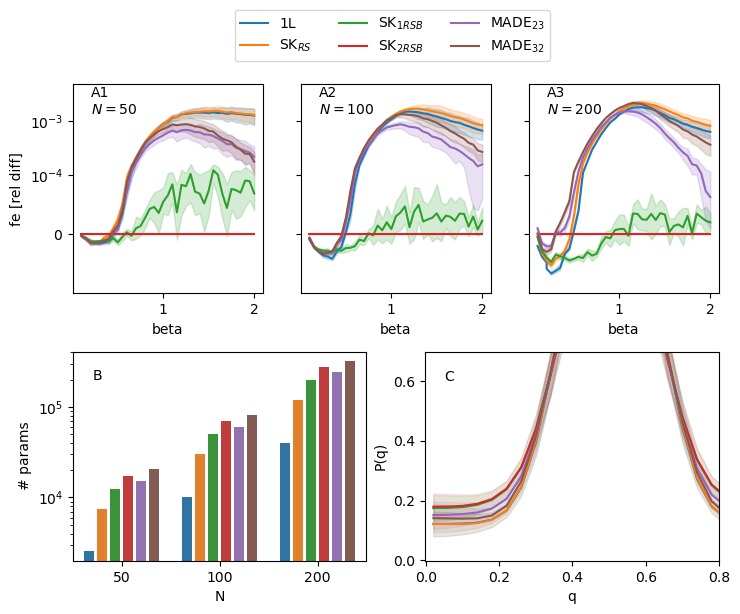

In [44]:
import itertools

fig = plt.figure(constrained_layout=True, figsize=(7.5, 5.5))
gs = fig.add_gridspec(2, 1)

gs00 = gs[0].subgridspec(1, 3)
gs01 = gs[1].subgridspec(1, 2)

to_pl_old = ["SL", "SK_0rsb", "SK_1rsb", "SK_2rsb", "MADE_23", "MADE_32"]

replacement = {'SL': '1L', "SK_0rsb": 'SK$_{RS}$', "SK_1rsb": 'SK$_{1RSB}$',
               "SK_2rsb": 'SK$_{2RSB}$', 'MADE_23': 'MADE$_{23}$', 'MADE_32': 'MADE$_{32}$'}

to_plt = [replacement[key] for key in replacement]

axs = [[], []]
axs[0].append(fig.add_subplot(gs00[0, 0]))
axs[0].append(fig.add_subplot(gs00[0, 1]))
axs[0].append(fig.add_subplot(gs00[0, 2]))
axs[1].append(fig.add_subplot(gs01[0, 0]))
axs[1].append(fig.add_subplot(gs01[0, 1]))
data['net_spec'] = data['net_spec'].replace(replacement)
data = data[data['net_spec'].isin(to_plt)]
Ns = [50, 100, 200]
# N=10
# #dd = data[N].rolling(5, on="beta").mean()
# sns.lineplot(data=data[N], x="beta", y="err_fe", hue="net_spec", ax=axs[0][0])
linthresh = 1e-4
ylimp = 0.005
ylimm = -0.0001

for i, N in enumerate(Ns):
    d_ = data[(data["N"] == N)]
    bb = sns.lineplot(data=d_, x="beta", y="err_fe_rel",
                      hue="net_spec", ax=axs[0][i], legend="full", hue_order=to_plt)
    axs[0][i].set_yscale('symlog', linthresh=linthresh)
    axs[0][i].set_ylim(ylimm, ylimp)


dd_ = data[(data["N"] > 20)]
aa = dd_.groupby(["N", "net_spec"]).mean().reset_index()
aa["logN"] = np.log(aa["N"])
# for N in Ns:
#    aa[aa["N"]==N]["num_params"] = data[data["N"]==N]["num_params"] + N*N
sns.barplot(data=aa, x="logN", y="num_params",
            hue="net_spec", ax=axs[1][0], hue_order=to_plt)
change_width(axs[1][0], .1)
axs[1][0].set_xticklabels(list(aa["N"].unique()))
# axs[0][0].legend()
axs[0][0].legend().remove()
axs[0][1].legend().remove()
axs[0][2].legend().remove()
axs[1][0].legend().remove()

axs[0][0].set_ylabel("fe [rel diff]")
axs[0][1].set_ylabel("")
axs[0][2].set_ylabel("")
axs[0][1].set_yticklabels("")
axs[0][2].set_yticklabels("")
#axs[0][0].set_ylim(-0.0005, 0.0037)
#axs[0][1].set_ylim(-0.0005, 0.0037)
#axs[0][2].set_ylim(-0.0005, 0.0037)

# axs[0][0].set_title(f"N={Ns[0]}")
# axs[0][1].set_title(f"N={Ns[1]}")
# axs[0][2].set_title(f"N={Ns[2]}")


axs[1][0].set_ylabel("# params")
axs[1][0].set_xticklabels(list(aa["N"].unique()))
axs[1][0].set_yscale("log")
axs[1][0].set_xlabel("N")

# plot overlap
beta = 1.5
N = 200
binned_q = pd.read_csv("./data/overlaps.zip")
colors = itertools.cycle(plt.rcParams['axes.prop_cycle'].by_key()['color'])

# plot the histograms
b_2 = int(len(binned_q["bins"])/2)
x = binned_q["bins"][b_2:]

for name in replacement.keys():
    y = (binned_q[name][:b_2].values + binned_q[name][b_2:].values)/2
    y_std = binned_q[name+"_std"].values/np.sqrt(10)
    y_std = np.sqrt(np.power(y_std[:b_2], 2) + np.power(y_std[b_2:], 2))
    color = next(colors)
    axs[1][1].plot(x, y, color=color, label=replacement[name])
    axs[1][1].fill_between(x, y - y_std/np.sqrt(10), y +
                           y_std/np.sqrt(10), color=color, alpha=0.1)
axs[1][1].set_xlabel("q")
axs[1][1].set_ylabel("P(q)")
axs[1][1].set_xlim(-0.002, 0.8)
axs[1][1].set_ylim(-0.002, 0.7)
handles, labels = axs[0][0].get_legend_handles_labels()

# Add a unified legend at the desired position
lgd = fig.legend(handles, labels, loc='upper center',
                 ncol=3, bbox_to_anchor=(0.53, 1.12))

# axs[0][0].get_legend().set_title("net")
axs[0][0].text(0.2, 0.0014, "A1\n$N=50$")
axs[0][1].text(0.2, 0.0014, "A2\n$N=100$")
axs[0][2].text(0.2, 0.0014, "A3\n$N=200$")
# axs[0][0].text(1.2, 0.0023, r"$N=50$")
# axs[0][1].text(1.2, 0.0023, r"$N=100$")
# axs[0][2].text(1.2, 0.0023, r"$N=200$")
axs[1][0].text(-0.3, 2e+5, "B")
axs[1][1].text(0.05, 0.6, "C")


# axs[0][0].legend(handlelength=1,)

# sns.move_legend(axs[1][0],(2.4,0.9))
plt.tight_layout()
plt.savefig("../tex/comphys_rev/img/SK_res.pdf",
            bbox_extra_artists=(lgd, ), bbox_inches='tight')

plt.show()
